In [2]:
library(XML)
library(TDA)
library(sets)
library(repr)
library(pracma)
library(gtools)
library(foreach)
library(stringr)
library(R.matlab)
library(doParallel)
library(scatterplot3d)

library(grid)
library(extrafont)
library(latex2exp)

library("ripserr")
library("graphics")
library("ggplot2")
library("scatterplot3d")

loadfonts(quiet = TRUE)
loadfonts(device = "postscript", quiet = TRUE)

names(postscriptFonts())

[1] "serif"                "sans"                 "mono"                
 [4] "AvantGarde"           "Bookman"              "Courier"             
 [7] "Helvetica"            "Helvetica-Narrow"     "NewCenturySchoolbook"
[10] "Palatino"             "Times"                "URWGothic"           
[13] "URWBookman"           "NimbusMon"            "NimbusSan"           
[16] "URWHelvetica"         "NimbusSanCond"        "CenturySch"          
[19] "URWPalladio"          "NimbusRom"            "URWTimes"            
[22] "ArialMT"              "ComputerModern"       "ComputerModernItalic"
[25] "Japan1"               "Japan1HeiMin"         "Japan1GothicBBB"     
[28] "Japan1Ryumin"         "Korea1"               "Korea1deb"           
[31] "CNS1"                 "GB1"

In [3]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames(diagram) = c("dimension", "Birth", "Death")
    
    return(diagram)    
}

## Calculate rips diagram using Ripser library
ripserDiag = function(X, dimension, threshold, format = "point-cloud"){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/dbhaskar92/ripser/ripser", 
                        args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), 
                        stdout = TRUE)
    
    return(parseOutput(ripserOut))
}

In [4]:
remote_mat_read <- function(r_url){
    
    mat_data = readMat(r_url)
    N = mat_data$N            # number of particle, 200
    alpha = mat_data$alpha    # fixed param, 1.5 
    beta = mat_data$beta      # fixed param, 0.5
    cA = mat_data$cA          # fixed param, 1.0
    cR = mat_data$cR
    iR = mat_data$iR
    lA = mat_data$lA          # fixed param, 1.0
    lR = mat_data$lR
    tseries = mat_data$t
    sim_data = mat_data$z
    tpoints = length(tseries) # number of timesteps, 2001
    
    if (length(sim_data) == tpoints * 6 * N){
        xpos = matrix(nrow = N, ncol = tpoints)
        ypos = matrix(nrow = N, ncol = tpoints)
        zpos = matrix(nrow = N, ncol = tpoints)
        xvel = matrix(nrow = N, ncol = tpoints)
        yvel = matrix(nrow = N, ncol = tpoints)
        zvel = matrix(nrow = N, ncol = tpoints)
        for (itr in seq(1, length(tseries))){
            xpos[,itr] = sim_data[itr, 1:N]
            ypos[,itr] = sim_data[itr, (N+1):(2*N)]
            zpos[,itr] = sim_data[itr, (2*N+1):(3*N)]
            xvel[,itr] = sim_data[itr, (3*N+1):(4*N)]
            yvel[,itr] = sim_data[itr, (4*N+1):(5*N)]
            zvel[,itr] = sim_data[itr, (5*N+1):(6*N)]
        }
        xpos[xpos > 11] = 11
        xpos[xpos < -11] = -11
        ypos[ypos > 11] = 11
        ypos[ypos < -11] = -11
        zpos[zpos > 11] = 11
        zpos[zpos < -11] = -11
        return(list("N" = N, "cR" = cR, "lR" = lR, "iR" = iR,
                   "xpos" = xpos, "ypos" = ypos, "zpos" = zpos,
                    "xvel" = xvel, "yvel" = yvel, "zvel" = zvel))
    } else {
        print("ERROR: Unexpected file size.")
        return(NULL)
    }
    
}

In [5]:
sim_data = remote_mat_read("data_long_3d_icR_3_ilR_3_cool_double_ring.mat")

In [7]:
str(sim_data)

List of 10
 $ N   : num [1, 1] 200
 $ cR  : num [1, 1] 0.9
 $ lR  : num [1, 1] 0.9
 $ iR  : NULL
 $ xpos: num [1:200, 1:40001] -0.629 -0.812 0.746 -0.827 -0.265 ...
 $ ypos: num [1:200, 1:40001] -0.2886 0.2428 -0.6232 -0.0657 0.2985 ...
 $ zpos: num [1:200, 1:40001] 0.1542 0.8115 -0.197 0.0582 -0.3919 ...
 $ xvel: num [1:200, 1:40001] -0.701 -0.121 -0.859 -0.393 -0.166 ...
 $ yvel: num [1:200, 1:40001] -0.367 0.736 -0.445 0.779 0.765 ...
 $ zvel: num [1:200, 1:40001] -0.262 0.29 -0.994 0.552 -0.305 ...


In [44]:
plot_sim <- function(xpos, ypos, zpos, tpoint){
    
    options(repr.plot.width=5, repr.plot.height=5)
    scatterplot3d(xpos[,tpoint], ypos[,tpoint], zpos[,tpoint], xlab="X", ylab="Y", zlab="Z")
    
}

In [12]:
max_sim_vel = max(max(sim_data$xvel), max(sim_data$yvel), max(sim_data$zvel))
min_sim_vel = min(min(sim_data$xvel), min(sim_data$yvel), min(sim_data$zvel))

In [15]:
max_pos = 12
min_pos = -12
max_vel = 12 
min_vel = -12

sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)
sim_data$zpos = (sim_data$zpos - min_pos)/(max_pos - min_pos)
sim_data$xvel = (sim_data$xvel - min_vel)/(max_vel - min_vel)
sim_data$yvel = (sim_data$yvel - min_vel)/(max_vel - min_vel)
sim_data$zvel = (sim_data$zvel - min_vel)/(max_vel - min_vel)

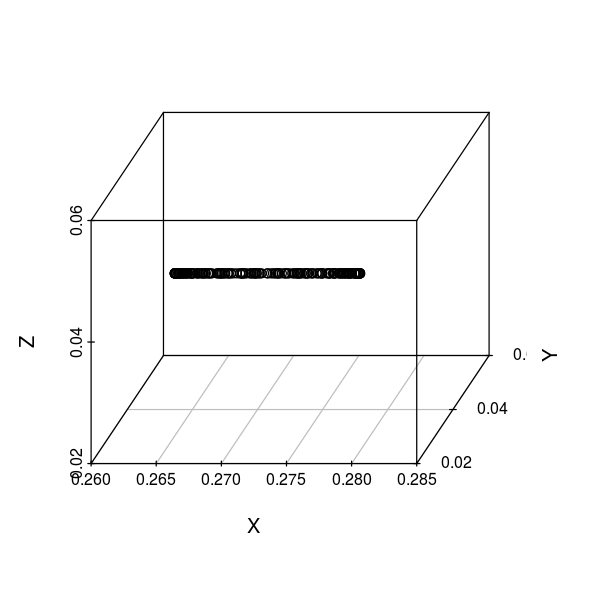

In [50]:
plot_sim(sim_data$xpos, sim_data$ypos, sim_data$zpos, 20000)

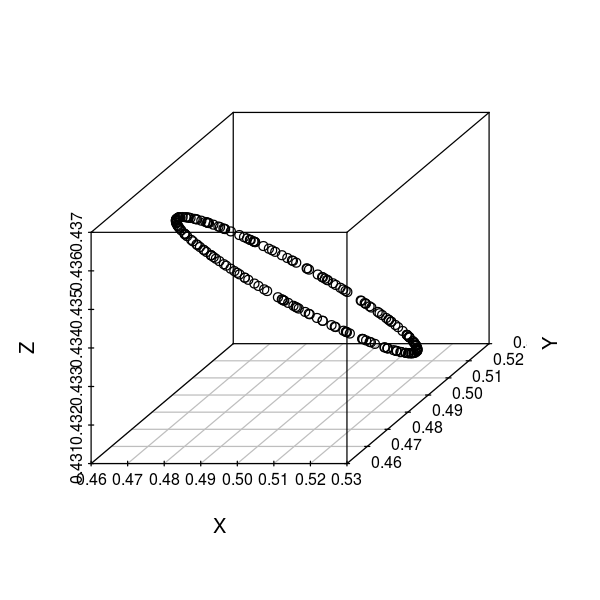

In [49]:
plot_sim(sim_data$xvel, sim_data$yvel, sim_data$zvel, 20000)

In [33]:
N = dim(sim_data$xpos)[1]
ntpoints = dim(sim_data$xpos)[2]

In [35]:
tsteps = seq(1, ntpoints, by=181)  # 40001/181 = 221 time points
ntsteps = length(tsteps)

eps_vals = logseq(0.0001, 1, n = 200)  
num_eps = length(eps_vals)

dim0Crocker = vector(mode = "list", length = (ntsteps-1)*num_eps)
dim1Crocker = vector(mode = "list", length = (ntsteps-1)*num_eps)
orderparams = vector(mode = "list", length = ntsteps-1)

In [39]:
i = 0
k = 0

for (tp in tsteps){  
    
    #if (tp == 1){
    #    next
    #}
    
    xdata = sim_data$xpos[,tp]
    ydata = sim_data$ypos[,tp]
    zdata = sim_data$zpos[,tp]
    xv = sim_data$xvel[,tp]
    yv = sim_data$yvel[,tp]
    zv = sim_data$zvel[,tp]
    xdata_old = sim_data$xpos[,tp-5]
    ydata_old = sim_data$ypos[,tp-5]
    zdata_old = sim_data$zpos[,tp-5]
    
    # run ripser
    homology <- ripserDiag(cbind(xdata, ydata, zdata, xv, yv, zv), 1, 50)
    intervals = as.data.frame(homology)
    dim0 = intervals[intervals$dimension==0,]
    dim1 = intervals[intervals$dimension==1,]
    
    num_feats_dim0 = dim(dim0)[1]
    num_feats_dim1 = dim(dim1)[1]
    
    # compute CROCKER plot
    for (eps in eps_vals){
        
        betti0 = sum((dim0$Birth < eps) & (dim0$Death > eps))
        betti1 = sum((dim1$Birth < eps) & (dim1$Death > eps))
        
        i = i + 1
        
        if (i == 1){
            dim0Crocker[i] = toString(c(i, tp, 0, eps, N))
        } else {
            dim0Crocker[i] = toString(c(i, tp, 0, eps, betti0+1))
        }
        
        dim1Crocker[i] = toString(c(ntsteps*num_eps + i, tp, 1, eps, betti1))
        
    }
    
    # compute order params
    
    # norm of the velocity
    v_norm = sqrt(xv^2 + yv^2 + zv^2)
    
    # center of mass
    c_x = mean(xdata)
    c_y = mean(ydata)
    c_z = mean(zdata)
      
    # mean centered positions
    r_x = xdata - c_x
    r_y = ydata - c_y
    r_z = zdata - c_z
    r_norm = sqrt(r_x^2 + r_y^2 + r_z^2)

    # polarization vector
    P = sqrt((sum(xv)/sum(v_norm))^2 + (sum(yv)/sum(v_norm))^2 + (sum(zv)/sum(v_norm))^2)
    
    k = k + 1
    orderparams[k] = toString(c(tp, P, 0, 0, 0))
    
}

cat("Expected: total number of rows = # time points * # eps values = 220 * 200 = 44000\n")
cat(c("Got: ", i))

Expected: total number of rows = # time points * # eps values = 220 * 200 = 44000
Got:  44200

In [40]:
fileConn = file("data_long_3d_icR_3_ilR_3_cool_double_ring_CD_pos_vel.csv")
writeLines(as.character(c(dim0Crocker, dim1Crocker)), fileConn)
close(fileConn)

In [38]:
fileConn = file("data_long_3d_icR_3_ilR_3_cool_double_ring_order_params.csv")
writeLines(as.character(orderparams), fileConn)
close(fileConn)